### This is a short notebook written to simulate delta hedging in the Black Scholes framework

### Basic steps will be:
#### 1) Solve geometric brownian motion for a random asset price path
#### 2) Use Black Scholes formula to calculate the price of an option based on that asset
#### 3) Step through asset evolution and reballance a replicating portfolio and hopefully match step 2 pirce 

In [9]:
import numpy as np
import math
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 15

### Step 1)

Geometric Brownian motion described by $\frac{dS}{S}=\mu dt+\sigma dB$
where $S$ is the underlying spot price, $\mu$ is the scale of the deterministic drift over time increment $dt$, and $\sigma$ is the scale of the random Brownian process $dB$ which are iid normally distributed values of either $\pm 1$

We use Ito's lemma (2D taylor expansion of a stochastic function): $df = \left(\frac{\partial f}{\partial S}\mu S+\frac{\partial f}{\partial t}+\frac{S^2\sigma^2}{2}\frac{\partial^2 f}{\partial S^2}\right)\,dt + S\sigma\frac{\partial f}{\partial S}\,dB$.

Take the function $f$ to be $\mathrm{ln}(S)$ such that $df=d\mathrm{ln}(S)=\left(\frac{\partial \mathrm{ln}(S)}{\partial S}\mu S+\frac{\partial \mathrm{ln}(S)}{\partial t}+\frac{S^2\sigma^2}{2}\frac{\partial^2 \mathrm{ln}(S)}{\partial S^2}\right)\,dt + S\sigma\frac{\partial \mathrm{ln}(S)}{\partial S}\,dB$.

However, $\frac{\partial \mathrm{ln}(S)}{\partial t}=0$, $\frac{\partial \mathrm{ln}(S)}{\partial S}=\frac{1}{S}$ and $\frac{\partial^2 \mathrm{ln}(S)}{\partial S^2}=\frac{-1}{S^2}$, so now, $d\mathrm{ln}(S)=\left(\frac{S\mu}{S}+0+\frac{-S^2\sigma^2}{S^2}\right)\,dt + \frac{S\sigma\,dB}{S}$,

or $d\mathrm{ln}(S)=\left(\mu-\frac{\sigma^2}{2}\right)\,dt+\sigma\,dB$.

Now $\int\limits_t^T d\mathrm{ln}(S)=\int\limits_t^T \left(\mu-\frac{\sigma^2}{2}\right)\,dt+ \int\limits_t^T \sigma\,dB$

which reduces to $\mathrm{ln}(S_T) - \mathrm{ln}(S_t) = \left(\mu-\frac{\sigma^2}{2}\right)(T-t) + \sigma\,B_T$

which rearranges to $S = S_t\mathrm{exp}\left[\left(\mu-\frac{\sigma^2}{2}\right)(T-t) + \sigma\,B_T\right]$.

Lastly, we take advantage of the scaling of $dB\sim\sqrt{dt}$ (derivation in https://github.com/Dan-Treacher/mathsAndFinance/stochasticCalculusNotes.pdf) to simplify the final part with $B_T=\sqrt{dt}Z_t$ where $Z_t$ are standard normally distributed numbers.

$S = S_t\mathrm{exp}\left[\left(\mu-\frac{\sigma^2}{2}\right)(T-t) + \sigma\sqrt{dt}Z_T\right]$
therefore describes the evolution of the underlying spot price $S$, which we can now simulate using only a set of normally distributed random numbers for $Z_T$


In [2]:
def assetPath(timeIncrements, nPaths, years=1, S0=10, r=0.05, sigma=0.2):
    
    """
    Inputs:
        timeIncrements: [int] Number of time increments you simulate the path over (251 trading days in a year)
        nPaths: [int] Number of independent price paths you want to simulate
        years: [float] Length of time you'll simulate over in years
        S0: [float] Initial price of the underlying
        r: [float] Risk free rate (assumed constant throughout simulation)
        sigma: [float] Volatility of the underlying (assumed constant). Necessarily positive
    """

    dt = years / timeIncrements
    S = np.zeros((timeIncrements+1, nPaths))
    S[0] = S0
    Z = np.random.standard_normal(S.shape)  # This is vectorised and nice and fast
    for t in range(1, timeIncrements+1):
        for i in range(nPaths):
            # Final equation in above derivation (implemented i times in parallel)
            S[t, i] = S[t-1, i]*math.exp(((r - (sigma**2)/2)*dt) + sigma*math.sqrt(dt)*Z[t, i])

    return S

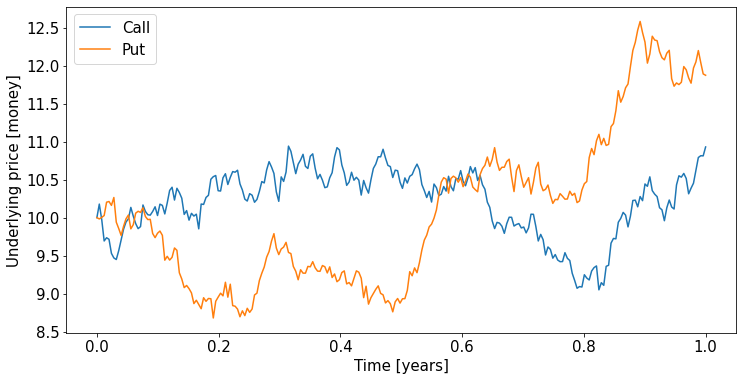

In [33]:
timeIncrements = 251
nPaths = 2

prices = assetPath(timeIncrements, nPaths)
plt.figure(1, figsize=(12,6))
plt.plot(np.linspace(0, 1, timeIncrements+1), prices)
plt.xlabel('Time [years]')
plt.ylabel('Underlying price [money]')
plt.legend(('Call', 'Put'))
plt.show()

### Step 2)

In [73]:
# Black Scholes formula describes the replicating portfolio consisting of a position in the underlying and borrowing some cash
# For a call option:

# Need the CDF of the standard normal distribution for the black scholes formula
def phi(x):
    return 0.5*(1.0 + math.erf(x / math.sqrt(2)))

def blackScholesFormula(strike, timeToMaturity=1, S0=10, r=0.05, sigma=0.2, option='Call'):
    d1 = (math.log(S0/strike) + ((r + (sigma**2)/2)*timeToMaturity)) / (sigma*math.sqrt(timeToMaturity))
    d2 = d1 - (sigma*math.sqrt(timeToMaturity))
    
    if option == 'Call':
        return S0*phi(d1) - (strike*math.exp(-r*timeToMaturity)*phi(d2))
    else:
        return -S0*phi(-d1) + (strike*math.exp(-r*timeToMaturity)*phi(-d2))

def delta_call(strike, timeToMaturity=1, S0=10, r=0.05, sigma=0.2):
    d1 = (math.log(S0/strike) + ((r + (sigma**2)/2)*timeToMaturity)) / (sigma*math.sqrt(timeToMaturity))
    return phi(d1)

def delta_put(strike, timeToMaturity=1, S0=10, r=0.05, sigma=0.2):
    d1 = (math.log(S0/strike) + ((r + (sigma**2)/2)*timeToMaturity)) / (sigma*math.sqrt(timeToMaturity))
    return phi(-d1)

In [58]:
# So for the example plot above of call and put option underlyings, we have the corresponding values:
print('Black Scholes value for the call option: ${:.2f}'.format(blackScholesFormula(strike=10, option='Call')))
print('Black Scholes value for the put option: ${:.2f}'.format(blackScholesFormula(strike=10, option='Put')))
print(' ')
print('Payoff for the call option was: ${:.2f}'.format(np.max([0,prices[-1,0] - 10])))  # Strike price of 10
print('Payoff for the put option was: ${:.2f}'.format(np.max([10 - prices[-1,1], 0])))  # Strike price of 10

Black Scholes value for the call option: $1.05
Black Scholes value for the put option: $0.56
 
Payoff for the call option was: $0.93
Payoff for the put option was: $0.00


### Step 3)

Delta hedging involves holding positions in the underlying and some cash which should, with sufficient reballancing, replicate the price of the option calculated by Black Scholes.

The amount of stock we need to have in this replicating portfolio is given by the delta of the underlying, which is the CDF of $d_1$ that appears above

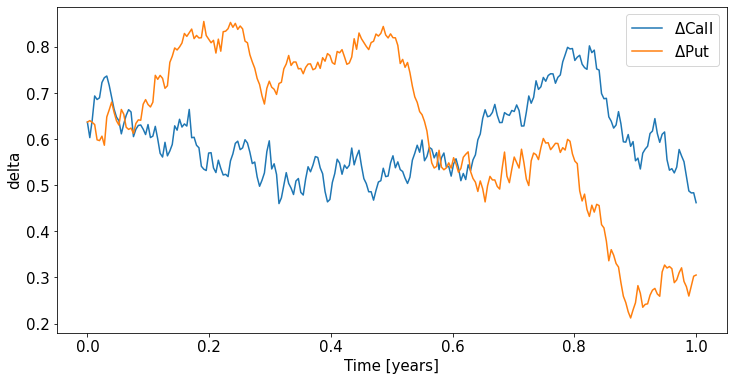

In [78]:
delta_call = list(map(delta, prices[:,0]))
delta_put = list(map(delta, prices[:,1]))
plt.figure(2, figsize=(12,6))
plt.plot(np.linspace(0, 1, timeIncrements+1), delta_call)
plt.plot(np.linspace(0, 1, timeIncrements+1), delta_put)
plt.xlabel('Time [years]')
plt.ylabel('delta')
plt.legend(('$\Delta$Call', '$\Delta$Put'))
plt.show()

The above plot of deltas of the two options describes the amount of stock we'd need to go long or short on at a given time in order to reballance our portfolio toward that of the replicating portfolio